# Analysis of PCA Results

Last updated: June 10, 2020

Author: Marc Richardson

In this notebook, we examine the results produced by the principal component analysis, which we used to reduce our five socioeconomic indicators down to a single score of socioeconomic status for each census tract. This notebook generates some descriptive statistics of the results and data visualizations.

In [1]:
import pandas as pd
import geopandas as gpd
import pysal

In [2]:
import dataset as ds
from dataset import SF_DICT

## 1. Loading ASC Data, PCA Results, PCA Inputs, PCA Loadings, and Geodata

In [3]:
DTYPES = {
    'geo11': str
}

# ACS 5-year data

acs_10 = \
    pd.read_csv('ACS/SES Ascent Datasets/acs5_2010_socioeconomic_vars.csv', dtype=DTYPES)
acs_11 = \
    pd.read_csv('ACS/SES Ascent Datasets/acs5_2011_socioeconomic_vars.csv', dtype=DTYPES)
acs_12 = \
    pd.read_csv('ACS/SES Ascent Datasets/acs5_2012_socioeconomic_vars.csv', dtype=DTYPES)
acs_13 = \
    pd.read_csv('ACS/SES Ascent Datasets/acs5_2013_socioeconomic_vars.csv', dtype=DTYPES)
acs_list = [acs_10, acs_11, acs_12, acs_13]
for acs in acs_list:
    acs.set_index('geo11', inplace=True)
    acs.drop([x for x in acs.columns if x not in ['Affiliated City', 'Median Annual Household Income']], axis=1, inplace=True)

# PCA Results

results_15 = pd.read_csv('relative_rank/in_between_ses_2010_2015.csv', 
                         dtype=DTYPES)
results_15['year'] = '2010-15'
results_16 = pd.read_csv('relative_rank/in_between_ses_2011_2016.csv', 
                         dtype=DTYPES)
results_16['year'] = '2011-16'
results_17 = pd.read_csv('relative_rank/in_between_ses_2012_2017.csv', 
                         dtype=DTYPES)
results_17['year'] = '2012-17'
results_18 = pd.read_csv('relative_rank/in_between_ses_2013_2018.csv', 
                         dtype=DTYPES)
results_18['year'] = '2013-18'
result_list = [results_15, results_16, results_17, results_18]
for df in result_list:
    df.set_index('geo11', inplace=True)
    df.drop('48017950100', inplace=True)

# PCA Inputs

inputs_15 = \
    pd.read_csv('relative_rank/in_between_inputs_pca_2010_2015.csv', dtype=DTYPES)
inputs_16 = \
    pd.read_csv('relative_rank/in_between_inputs_pca_2011_2016.csv', dtype=DTYPES)
inputs_17 = \
    pd.read_csv('relative_rank/in_between_inputs_pca_2012_2017.csv', dtype=DTYPES)
inputs_18 = \
    pd.read_csv('relative_rank/in_between_inputs_pca_2013_2018.csv', dtype=DTYPES)
input_list = [inputs_15, inputs_16, inputs_17, inputs_18]
for df in input_list:
    df.set_index('geo11', inplace=True)

# Merge Results with ACS Data to get Cities and Income Data

merged_15 = pd.merge(results_15, acs_10, how='inner', left_index=True, right_index=True)
merged_16 = pd.merge(results_16, acs_11, how='inner', left_index=True, right_index=True)
merged_17 = pd.merge(results_17, acs_12, how='inner', left_index=True, right_index=True)
merged_18 = pd.merge(results_18, acs_13, how='inner', left_index=True, right_index=True)
merged_list = [merged_15, merged_16, merged_17, merged_18]

# PCA loadings

loadings_15 = pd.read_csv('loadings/box_cox_loadings_2010_2015.csv')
loadings_16 = pd.read_csv('loadings/box_cox_loadings_2011_2016.csv')
loadings_17 = pd.read_csv('loadings/box_cox_loadings_2012_2017.csv')
loadings_18 = pd.read_csv('loadings/box_cox_loadings_2013_2018.csv')
loadings = list((loadings_15, loadings_16, loadings_17, loadings_18))
for i, l in enumerate(loadings):
    l.rename(columns={'Unnamed: 0': 'Components',
                  '0': 'First Principal Component', 
                  '1': 'Second Principal Component',
                  '2': 'Third Principal Component',
                  '3': 'Fourth Principal Component', 
                  '4': 'Fifth Principal Component'}, inplace=True)
    l.set_index('Components', inplace=True)
    loadings[i] = l.transpose()
loadings_15, loadings_16, loadings_17, loadings_18 = loadings
loadings_15['year'] = '2010-15'
loadings_16['year'] = '2011-16'
loadings_17['year'] = '2012-17'
loadings_18['year'] = '2013-18'
loadings_15['Comp. No.'] = ['1', '2', '3', '4', '5']
loadings_16['Comp. No.'] = ['1', '2', '3', '4', '5']
loadings_17['Comp. No.'] = ['1', '2', '3', '4', '5']
loadings_18['Comp. No.'] = ['1', '2', '3', '4', '5']
loadings = list((loadings_15, loadings_16, loadings_17, loadings_18))

In [4]:
# State Shape Files
def load_state_shapefile(file_path):
    
    gdf = gpd.read_file(file_path)
    gdf.rename(columns={'GEOID10': 'geo11'}, inplace=True)
    gdf.set_index('geo11', inplace=True)
    
    return gdf

# City shapefiles

chicago = gpd.read_file(
    'shapefiles/Boundaries - Census Tracts - 2010.geojson')
chicago.rename(columns={'geoid10': 'geo11'}, inplace=True)
chicago.set_index('geo11', inplace=True)

# State Shape Files
GDF_DICT = {}
for state, file in SF_DICT.items():

    GDF_DICT[state] = load_state_shapefile(file)

## 2. Helper Functions

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
wd = os.getcwd()
IMAGES = os.path.join(wd, 'plots')
if not os.path.exists(IMAGES):
    os.mkdir(IMAGES)
DISTRIBUTIONS = os.path.join(IMAGES, "distributions")
SCATTER = os.path.join(IMAGES, "scatter")
BOX = os.path.join(IMAGES, "box_plots")
MAPS = os.path.join(IMAGES, 'maps')

# Data visualization functions

def show_distribution(column, title, legend_labels):
    """
    Plot distribution of a variable in results tables
    """
    sns.set(style='darkgrid')
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    g0 = sns.distplot(results_15[column], ax=ax, kde_kws={'lw': 4}, hist_kws={'alpha': 0.6})
    g1 = sns.distplot(results_16[column], ax=ax, kde_kws={'lw': 4}, hist_kws={'alpha': 0.6})
    g2 = sns.distplot(results_17[column], ax=ax, kde_kws={'lw': 4}, hist_kws={'alpha': 0.6})
    g3 = sns.distplot(results_18[column], ax=ax, kde_kws={'lw': 4}, hist_kws={'alpha': 0.6})
    ax.legend(legend_labels)
    ax.set_title(title, fontdict=dict([('fontsize', 18), ('fontweight', 3)]))
    ax.set_xlabel(" ".join(column.split('_')))
    plt.show()
    if not os.path.exists(DISTRIBUTIONS):
        os.mkdir(DISTRIBUTIONS)
    fig.savefig(os.path.join(DISTRIBUTIONS, title + '.png'))

def show_scatter(x, y, title, x_range, y_range):
    """
    Scatterplot of variables in results tables
    """
    sns.set(style='darkgrid')
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    data = pd.DataFrame()
    for df in result_list:
        data = pd.concat((data, df))
    sns.scatterplot(x=x, y=y, data=data, ax=ax, alpha=0.35, hue='year', palette='tab10')
    ax.set_title(title, fontdict=dict([('fontsize', 18), ('fontweight', 3)]))
    plt.plot(x_range, y_range, color='k', lw=2)
    plt.show()
    if not os.path.exists(SCATTER):
        os.mkdir(SCATTER)
    fig.savefig(os.path.join(SCATTER, title + '.png'))

def show_boxplot(column, title):
    """
    Boxplot of variable in results
    """
    sns.set(style='darkgrid')
    data = pd.DataFrame()
    for df in result_list:
        data = pd.concat((data, df))
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(x=column, y='year', orient='h', data=data, ax=ax)
    ax.set_title(title, fontdict=dict([('fontsize', 18), ('fontweight', 3)]))
    plt.show()
    if not os.path.exists(BOX):
        os.mkdir(BOX)
    fig.savefig(os.path.join(BOX, title + '.png'))

def create_map(gdf, dfs, column, title, scheme=None, cmap='cividis'):
    """
    Map plot generation
    """
    
    sns.set(style='white')
    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, 3)
    ax4 = fig.add_subplot(2, 2, 4)
    ax1.set_title('2010-2015', fontdict={'fontsize': 18})
    ax2.set_title('2011-2016', fontdict={'fontsize': 18})
    ax3.set_title('2012-2017', fontdict={'fontsize': 18})
    ax4.set_title('2013-2018', fontdict={'fontsize': 18})
    legend_kwds = {'orientation': 'horizontal'}
    axes = [ax1, ax2, ax3, ax4]
    for ax in axes:
        ax.axis('off')
    fig.suptitle(title, fontsize=24)
    
    for ax, df in zip(axes, dfs):
        map_data = \
            gpd.GeoDataFrame(pd.merge(gdf, df, how='inner',
                                      left_index=True, right_index=True), 
                             crs=gdf.crs)[[column, 'geometry']]
        map_data.plot(column=column, linewidth=0.1, ax=ax, edgecolor='0.8', cmap=cmap, legend=True, scheme=scheme)
    plt.show()
    if not os.path.exists(MAPS):
        os.mkdir(MAPS)
    fig.savefig(os.path.join(MAPS, title + '.png'))

## 3. Quick Look at summary statistics of indicators (PCA inputs)

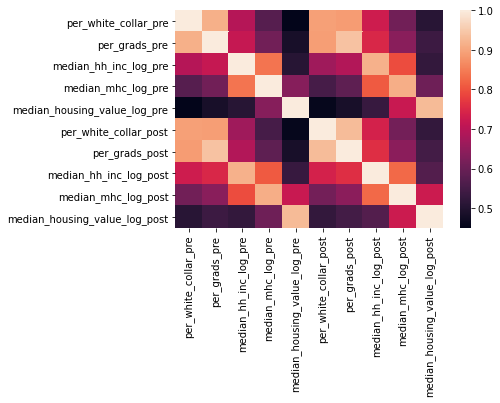

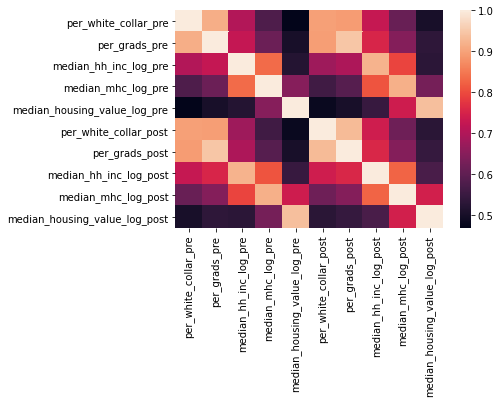

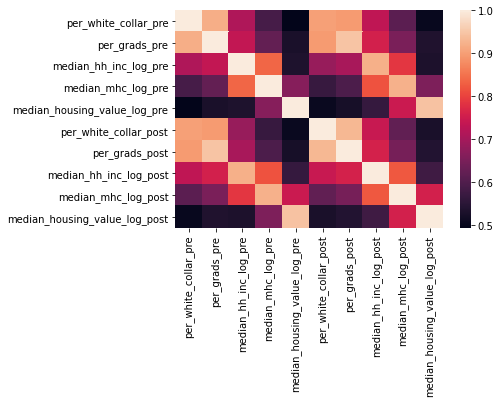

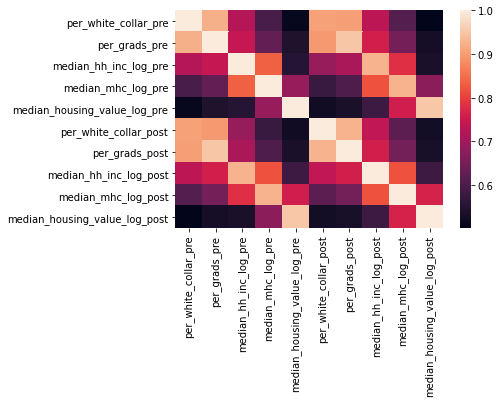

In [6]:
for df in input_list:
    sns.heatmap((df.corr()))
    plt.show()

In [7]:
inputs_15.describe()

,per_white_collar_pre,per_grads_pre,median_hh_inc_log_pre,median_mhc_log_pre,median_housing_value_log_pre,per_white_collar_post,per_grads_post,median_hh_inc_log_post,median_mhc_log_post,median_housing_value_log_post
count,11993.000000,11993.000000,11993.000000,11993.000000,11993.000000,11993.000000,11993.000000,11993.000000,11993.000000,11993.000000
mean,0.356855,0.376579,1439.306826,7.069500,12.597592,0.371627,0.400471,1482.645711,7.110669,12.509857
std,0.183246,0.217154,481.659261,0.385668,0.727589,0.186210,0.220599,512.264888,0.375688,0.791091
min,0.000000,0.000000,184.152451,5.170484,9.210240,0.000000,0.000000,424.236496,5.075174,9.210240
25%,0.212602,0.200938,1092.976171,6.825460,12.144197,0.222126,0.218310,1105.362930,6.873164,11.995352
50%,0.331361,0.338764,1382.050030,7.058758,12.754483,0.346010,0.364033,1415.295470,7.110696,12.638829
75%,0.488818,0.533759,1721.279984,7.319865,13.103588,0.506404,0.565392,1785.490236,7.356280,13.044618
max,1.000000,1.000000,3968.513213,8.294300,13.815512,1.000000,1.000000,3968.513213,8.294300,14.508658


In [8]:
inputs_16.describe()

,per_white_collar_pre,per_grads_pre,median_hh_inc_log_pre,median_mhc_log_pre,median_housing_value_log_pre,per_white_collar_post,per_grads_post,median_hh_inc_log_post,median_mhc_log_post,median_housing_value_log_post
count,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000,12003.000000
mean,0.360092,0.380085,1456.623624,7.097557,12.567348,0.377148,0.408278,1514.803900,7.127071,12.550035
std,0.184071,0.217784,491.835894,0.382505,0.726980,0.187092,0.221267,524.635260,0.376898,0.802994
min,0.000000,0.000000,330.192725,5.176150,9.210240,0.000000,0.000000,359.454485,5.337538,9.210240
25%,0.213100,0.201427,1101.740582,6.853299,12.108184,0.225077,0.224087,1127.768097,6.885510,12.022150
50%,0.334867,0.341239,1395.609848,7.085064,12.702596,0.352622,0.375163,1451.726516,7.132498,12.689116
75%,0.491979,0.538762,1746.839144,7.349231,13.074643,0.514656,0.573913,1824.991663,7.377134,13.091182
max,1.000000,1.000000,3968.513213,8.294300,13.815512,1.000000,1.000000,3968.513213,8.294300,14.508658


In [9]:
inputs_17.describe()

,per_white_collar_pre,per_grads_pre,median_hh_inc_log_pre,median_mhc_log_pre,median_housing_value_log_pre,per_white_collar_post,per_grads_post,median_hh_inc_log_post,median_mhc_log_post,median_housing_value_log_post
count,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000,12002.000000
mean,0.362030,0.383762,1459.002573,7.108341,12.522487,0.382944,0.415542,1562.263166,7.156118,12.605543
std,0.184377,0.218223,494.902563,0.379742,0.738172,0.187300,0.222465,541.127323,0.379641,0.812942
min,0.000000,0.000000,321.476562,5.225747,9.210240,0.000000,0.000000,318.420353,5.141664,9.210240
25%,0.213626,0.203869,1099.932205,6.867974,12.049565,0.230472,0.231088,1164.342809,6.913986,12.064653
50%,0.336976,0.346634,1401.786456,7.098376,12.635417,0.358155,0.380766,1498.291093,7.166266,12.751590
75%,0.495386,0.545020,1751.493680,7.355641,13.043428,0.523285,0.583779,1881.170546,7.407318,13.159368
max,1.000000,1.000000,3968.513213,8.294300,13.815512,1.000000,1.000000,3968.513213,8.294300,14.508658


In [10]:
inputs_18.describe()

,per_white_collar_pre,per_grads_pre,median_hh_inc_log_pre,median_mhc_log_pre,median_housing_value_log_pre,per_white_collar_post,per_grads_post,median_hh_inc_log_post,median_mhc_log_post,median_housing_value_log_post
count,12001.000000,12001.000000,12001.000000,12001.000000,12001.000000,12001.000000,12001.000000,12001.000000,12001.000000,12001.000000
mean,0.364513,0.388315,1461.550956,7.110117,12.484754,0.389218,0.423029,1614.996221,7.192010,12.669209
std,0.184981,0.219196,497.961567,0.376312,0.751872,0.187692,0.222780,557.712948,0.382296,0.818748
min,0.000000,0.000000,278.312335,5.257495,9.210240,0.000000,0.000000,408.752296,5.214936,9.210240
25%,0.215608,0.207696,1096.220368,6.873164,12.013095,0.237296,0.238320,1204.783022,6.951772,12.129731
50%,0.339109,0.352223,1401.457025,7.102499,12.586903,0.364979,0.390832,1550.803197,7.204149,12.814206
75%,0.496606,0.548856,1752.377661,7.355641,13.013441,0.531389,0.593629,1939.634658,7.445418,13.229782
max,1.000000,1.000000,3968.513213,8.294300,13.815512,1.000000,1.000000,3968.513213,8.294300,14.508658


## 4. Analyzing Loadings

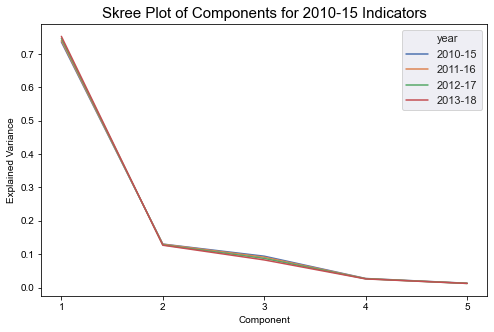

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 5))
data = pd.DataFrame()
for l in loadings:
    data = pd.concat((data, l))
sns.set(style='darkgrid')
sns.lineplot(x='Comp. No.', y='Explained Variance', data=data, hue='year', ax=ax)
ax.set_xlabel('Component')
ax.set_title('Skree Plot of Components for 2010-15 Indicators', fontdict={'fontsize': 15})
plt.show()
fig.savefig(os.path.join(IMAGES, 'skree.png'))

In [12]:
loadings_15

Components,per_white_collar,per_grads,median_hh_inc_box,median_mhc_box,median_housing_value_box,Explained Variance,year,Comp. No.
First Principal Component,0.339935,0.339986,0.419282,0.440462,0.330759,0.736219,2010-15,1
Second Principal Component,0.402272,0.347011,-0.064747,-0.483318,-0.731721,0.130184,2010-15,2
Third Principal Component,0.259011,0.225064,-0.531792,-0.457645,0.618819,0.093825,2010-15,3
Fourth Principal Component,0.081012,0.101777,-0.746032,0.602176,-0.273406,0.027009,2010-15,4
Fifth Principal Component,-0.697552,0.715021,-0.014743,-0.049157,-0.020129,0.012763,2010-15,5


In [13]:
loadings_16

Components,per_white_collar,per_grads,median_hh_inc_box,median_mhc_box,median_housing_value_box,Explained Variance,year,Comp. No.
First Principal Component,0.344187,0.343268,0.420246,0.445227,0.345696,0.740166,2011-16,1
Second Principal Component,0.399749,0.347672,-0.046538,-0.479651,-0.733741,0.129683,2011-16,2
Third Principal Component,0.267310,0.225254,-0.550135,-0.454814,0.601381,0.090942,2011-16,3
Fourth Principal Component,0.089720,0.092849,-0.734465,0.608086,-0.291584,0.026649,2011-16,4
Fifth Principal Component,0.698084,-0.714540,0.029096,0.045183,0.021178,0.012559,2011-16,5


In [14]:
loadings_17

Components,per_white_collar,per_grads,median_hh_inc_box,median_mhc_box,median_housing_value_box,Explained Variance,year,Comp. No.
First Principal Component,0.341025,0.340376,0.422723,0.446586,0.353026,0.746677,2012-17,1
Second Principal Component,0.404070,0.354600,-0.022674,-0.471660,-0.727388,0.127803,2012-17,2
Third Principal Component,0.273779,0.228954,-0.565801,-0.448354,0.586935,0.087223,2012-17,3
Fourth Principal Component,0.093856,0.085565,-0.723860,0.611816,-0.312135,0.026128,2012-17,4
Fifth Principal Component,0.692866,-0.719747,0.031306,0.035452,0.017022,0.012169,2012-17,5


In [15]:
loadings_18

Components,per_white_collar,per_grads,median_hh_inc_box,median_mhc_box,median_housing_value_box,Explained Variance,year,Comp. No.
First Principal Component,0.343541,0.342025,0.427426,0.447021,0.361921,0.752789,2013-18,1
Second Principal Component,0.407988,0.361225,-0.024068,-0.471422,-0.719609,0.126701,2013-18,2
Third Principal Component,0.273729,0.219944,-0.590509,-0.430523,0.579429,0.082630,2013-18,3
Fourth Principal Component,0.094606,0.087990,-0.697544,0.634331,-0.319870,0.025691,2013-18,4
Fifth Principal Component,-0.688986,0.723415,-0.031807,-0.034266,-0.008584,0.012190,2013-18,5


## 5. Visualizing PCA Results

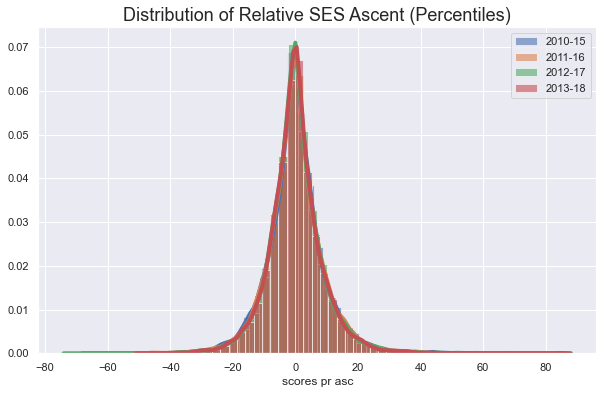

In [16]:
show_distribution('scores_pr_asc', 
                  'Distribution of Relative SES Ascent (Percentiles)',
                  ('2010-15', '2011-16', '2012-17', '2013-18'))

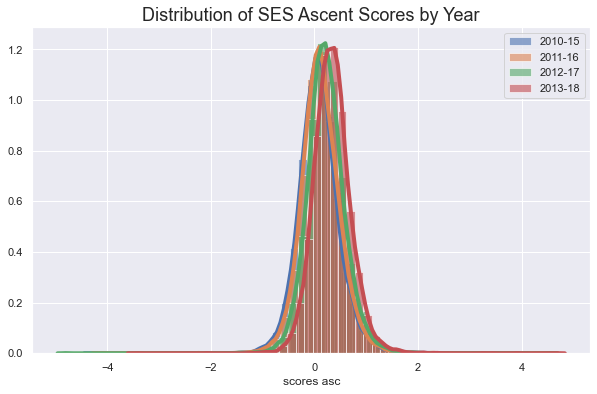

In [17]:
show_distribution('scores_asc', 
                  'Distribution of SES Ascent Scores by Year', 
                  ('2010-15', '2011-16', '2012-17', '2013-18'))

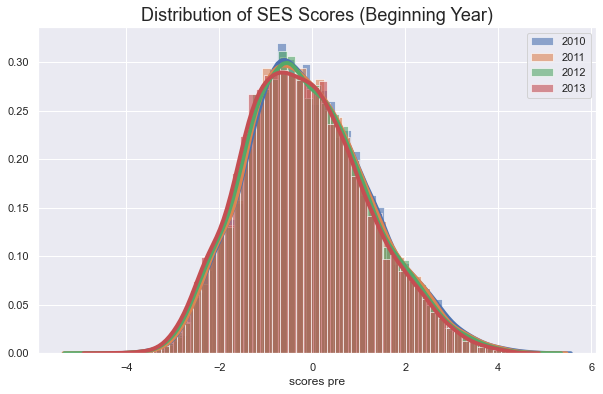

In [18]:
show_distribution('scores_pre', 
                  'Distribution of SES Scores (Beginning Year)',
                  ('2010', '2011', '2012', '2013'))

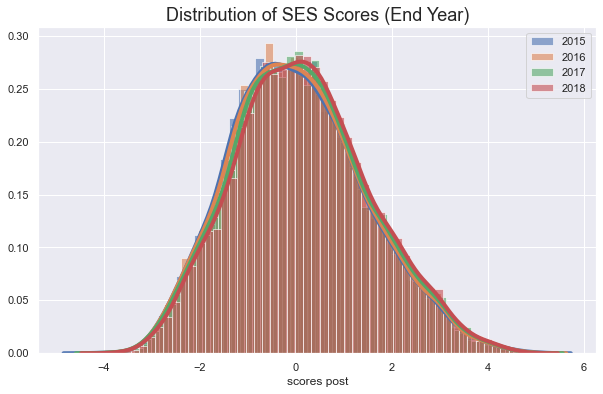

In [19]:
show_distribution('scores_post', 
                  'Distribution of SES Scores (End Year)',
                  ('2015', '2016', '2017', '2018'))

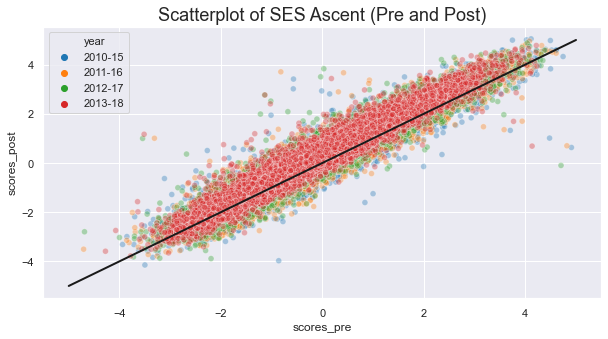

In [20]:
show_scatter('scores_pre', 
             'scores_post', 
             'Scatterplot of SES Ascent (Pre and Post)',
            [-5, 0, 5], [-5, 0, 5])

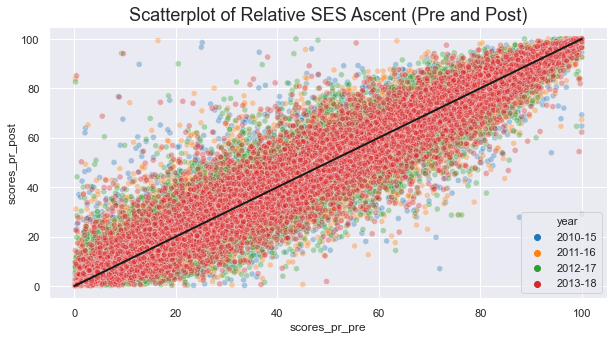

In [21]:
show_scatter('scores_pr_pre', 
             'scores_pr_post', 
             'Scatterplot of Relative SES Ascent (Pre and Post)',
            [0, 100], [0, 100])

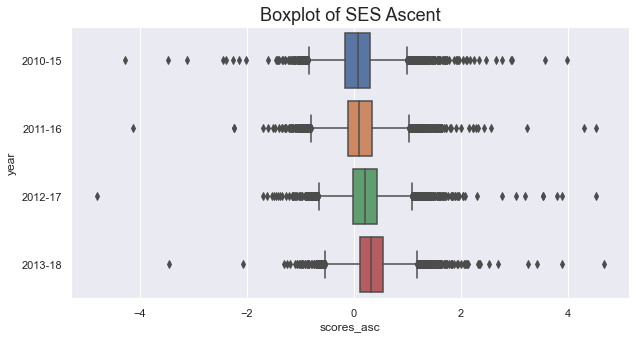

In [22]:
show_boxplot('scores_asc', 'Boxplot of SES Ascent')

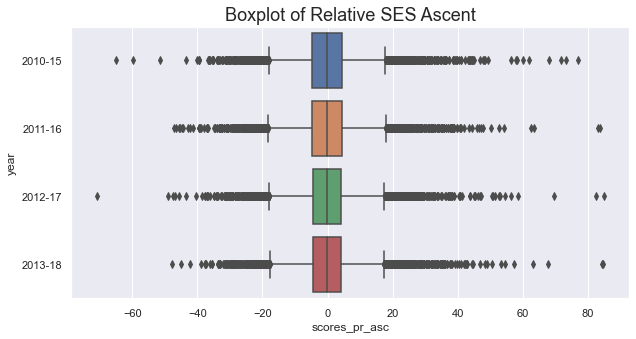

In [23]:
show_boxplot('scores_pr_asc', 'Boxplot of Relative SES Ascent')

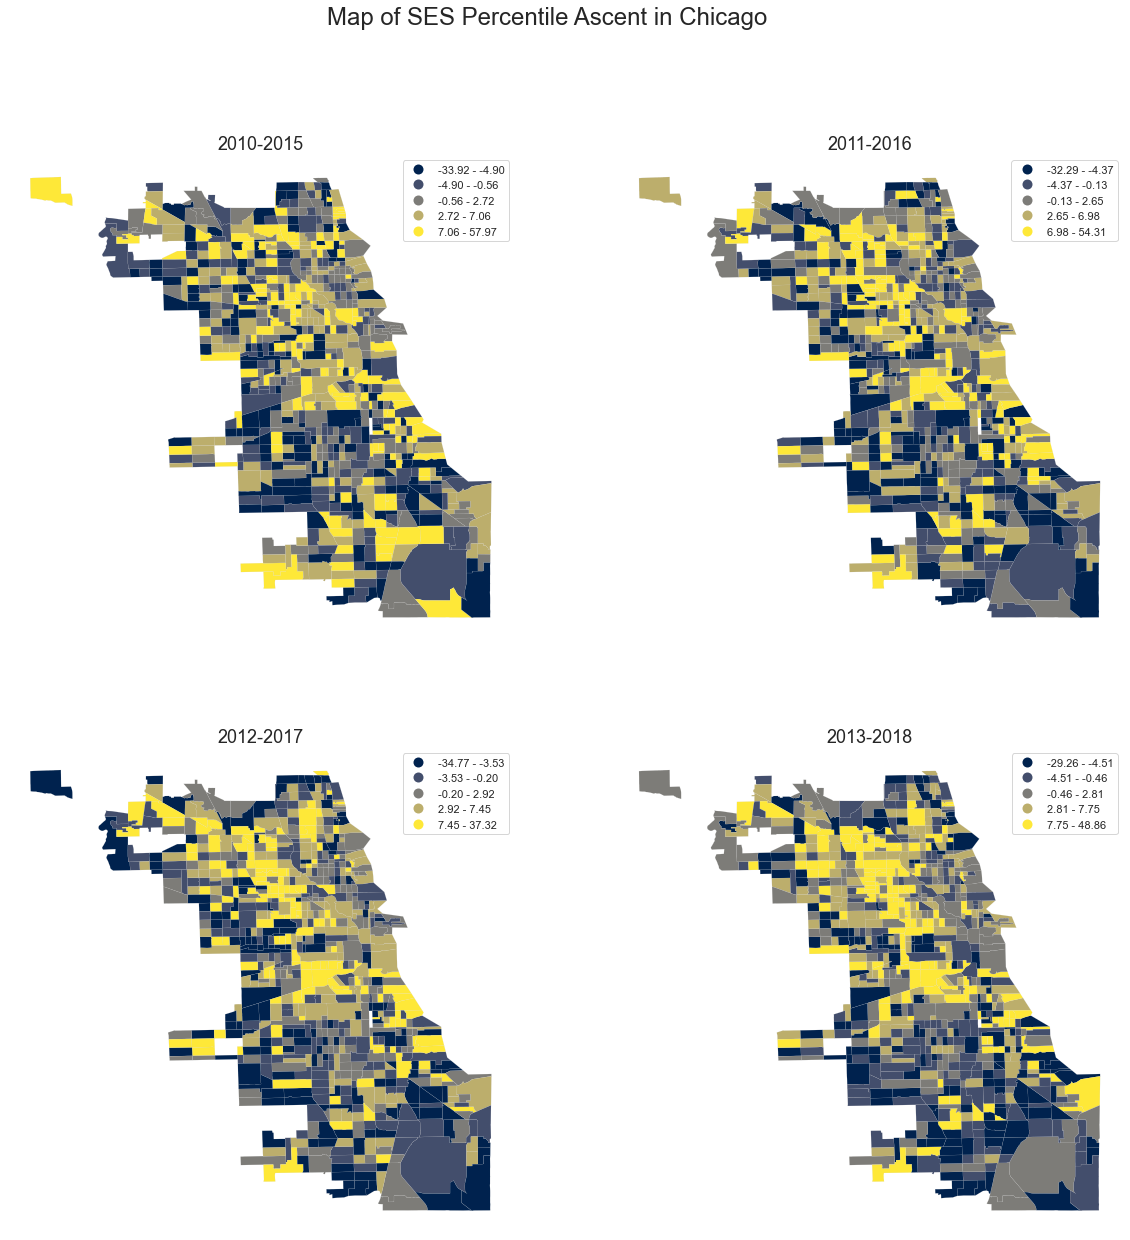

In [24]:
create_map(chicago, result_list, 
           'scores_pr_asc',
           'Map of SES Percentile Ascent in Chicago',
           'quantiles',
           cmap='cividis')

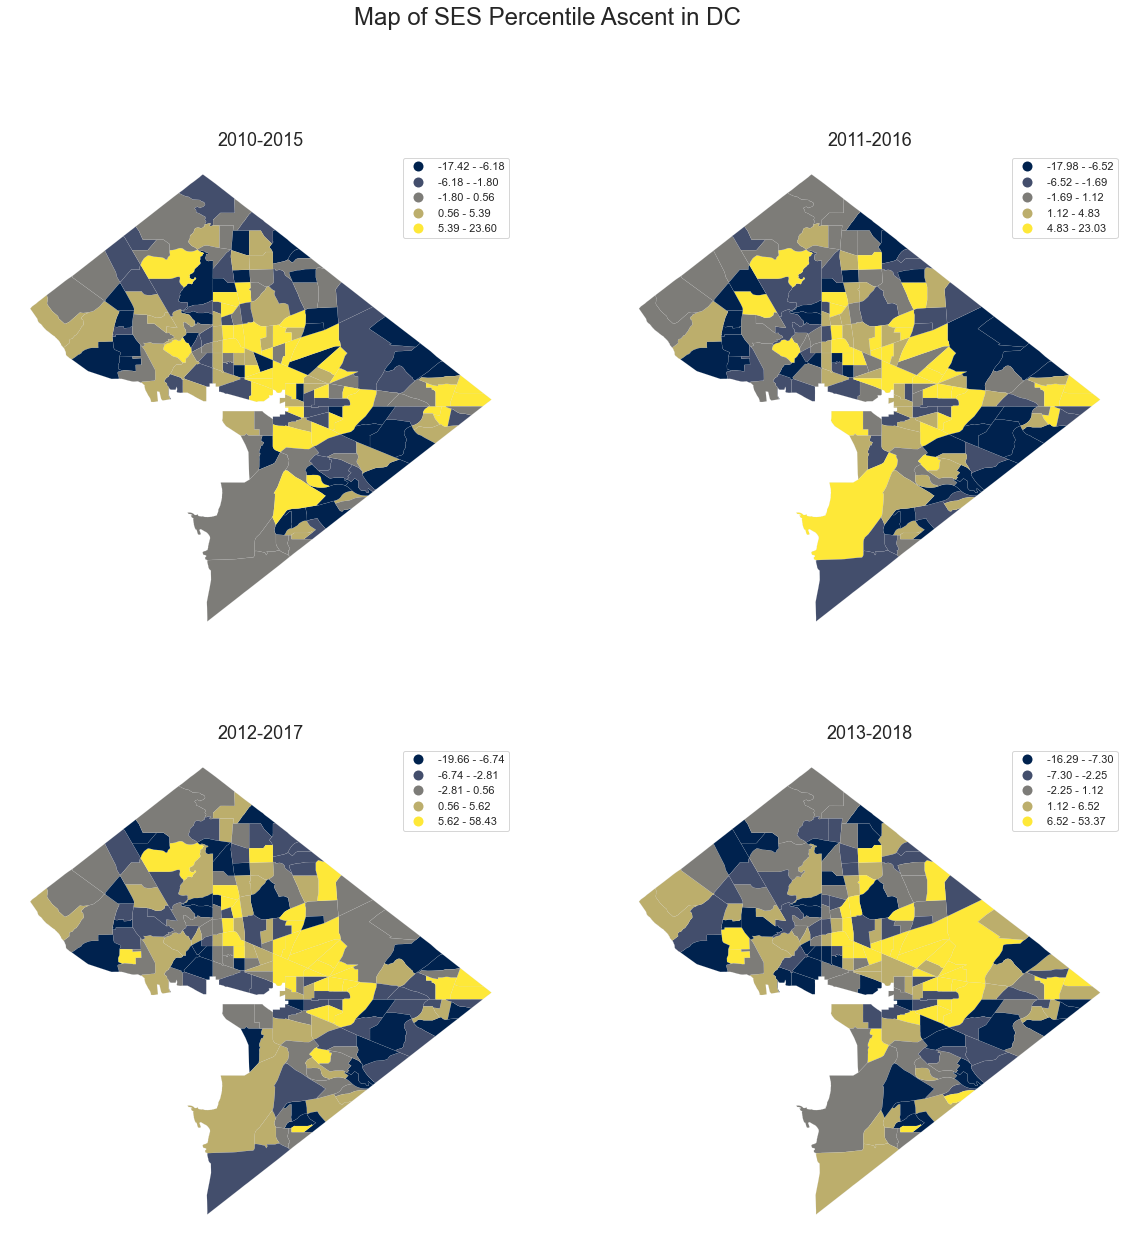

In [25]:
create_map(GDF_DICT['District of Columbia'], 
           result_list,
           'scores_pr_asc',
           'Map of SES Percentile Ascent in DC',
           'quantiles',
           cmap='cividis')

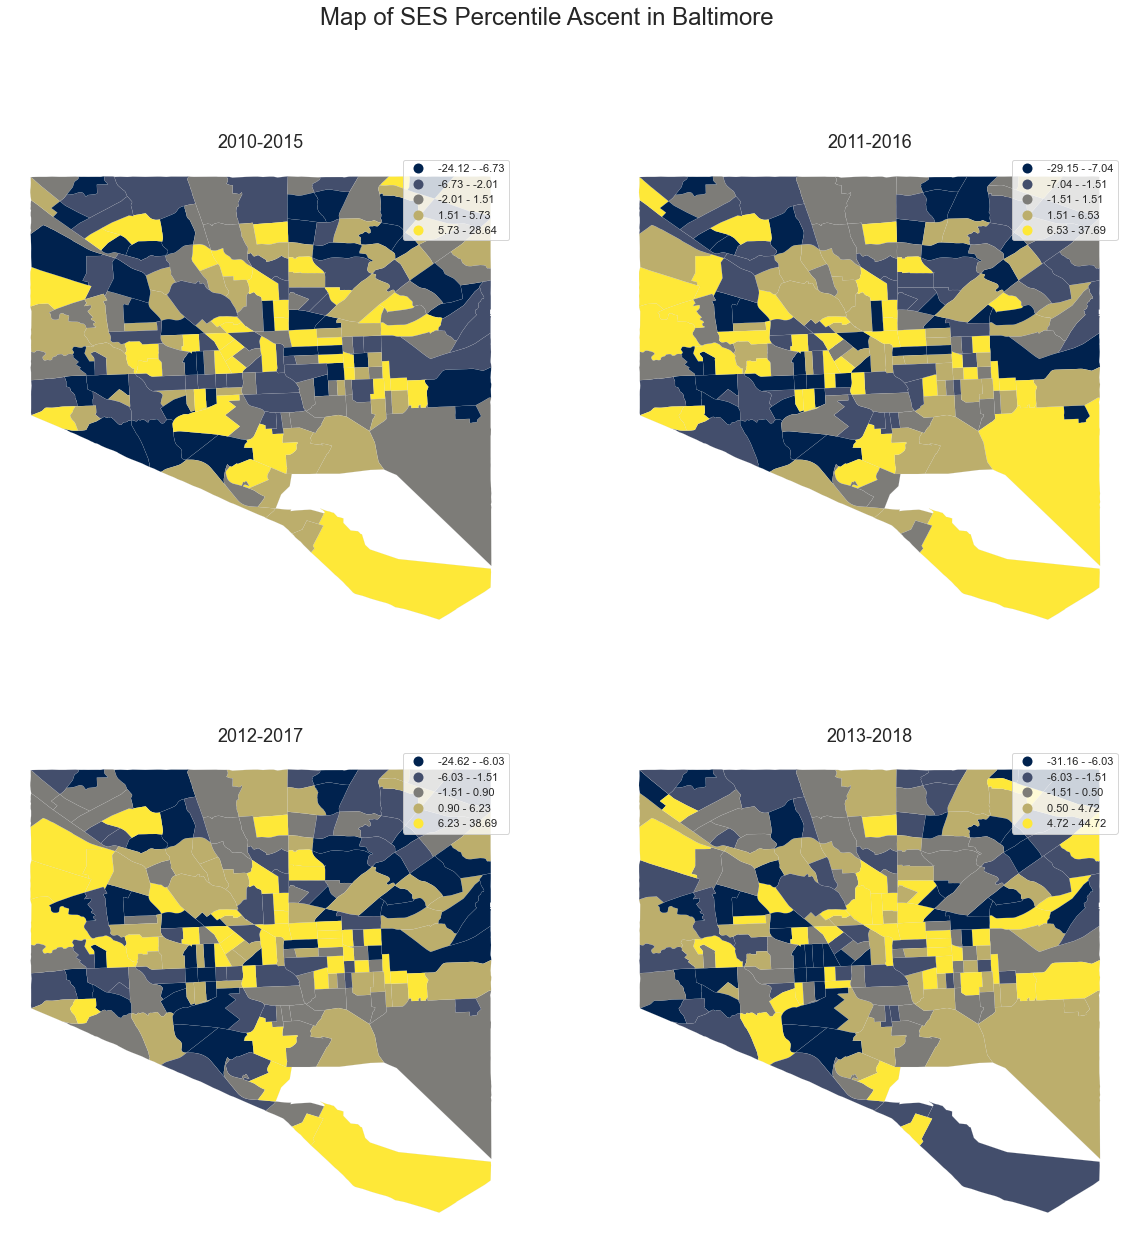

In [26]:
create_map(GDF_DICT['Maryland'], 
           result_list,
           'scores_pr_asc',
           'Map of SES Percentile Ascent in Baltimore', 
           'quantiles',
           cmap='cividis')

## 5. Identifying Gentrifying Tracts Among Tracts That Ascended

In [27]:
def generate_binary(data):
    
    for df in data:
        df['Ascended'] = df['scores_pr_asc'].map(lambda x: 1 if x > 0 else 0)
        df['Ascended_Raw'] = df['scores_asc'].map(lambda x: 1 if x > 0 else 0)

def find_lower_income_ascent(data, q=4, lb=1, ub=4):
    for df in data:
        df['Income Quartile'] = \
            df.groupby('Affiliated City')['Median Annual Household Income'].transform(
                    lambda x: pd.qcut(x, q=q, labels=range(1,q+1)))
        filtered = df[df['Ascended'] == 1]
        df['Ascent (Per) Quartile'] = \
            filtered.groupby('Affiliated City')['scores_pr_asc'].transform(
                        lambda x: pd.qcut(x, q=q, labels=range(1,q+1)))
        df['Bottom Income'] = df['Income Quartile'].map(lambda x: 1 if x <= lb else 0)
        df['Top (Per) Ascent'] = df['Ascent (Per) Quartile'].map(lambda x: 1 if x >= ub else 0)
        df['Lower Income Ascent'] = df['Bottom Income'] * df['Top (Per) Ascent']
        df.fillna({'Lower Income Ascent': 0}, inplace=True)

In [28]:
generate_binary(merged_list)

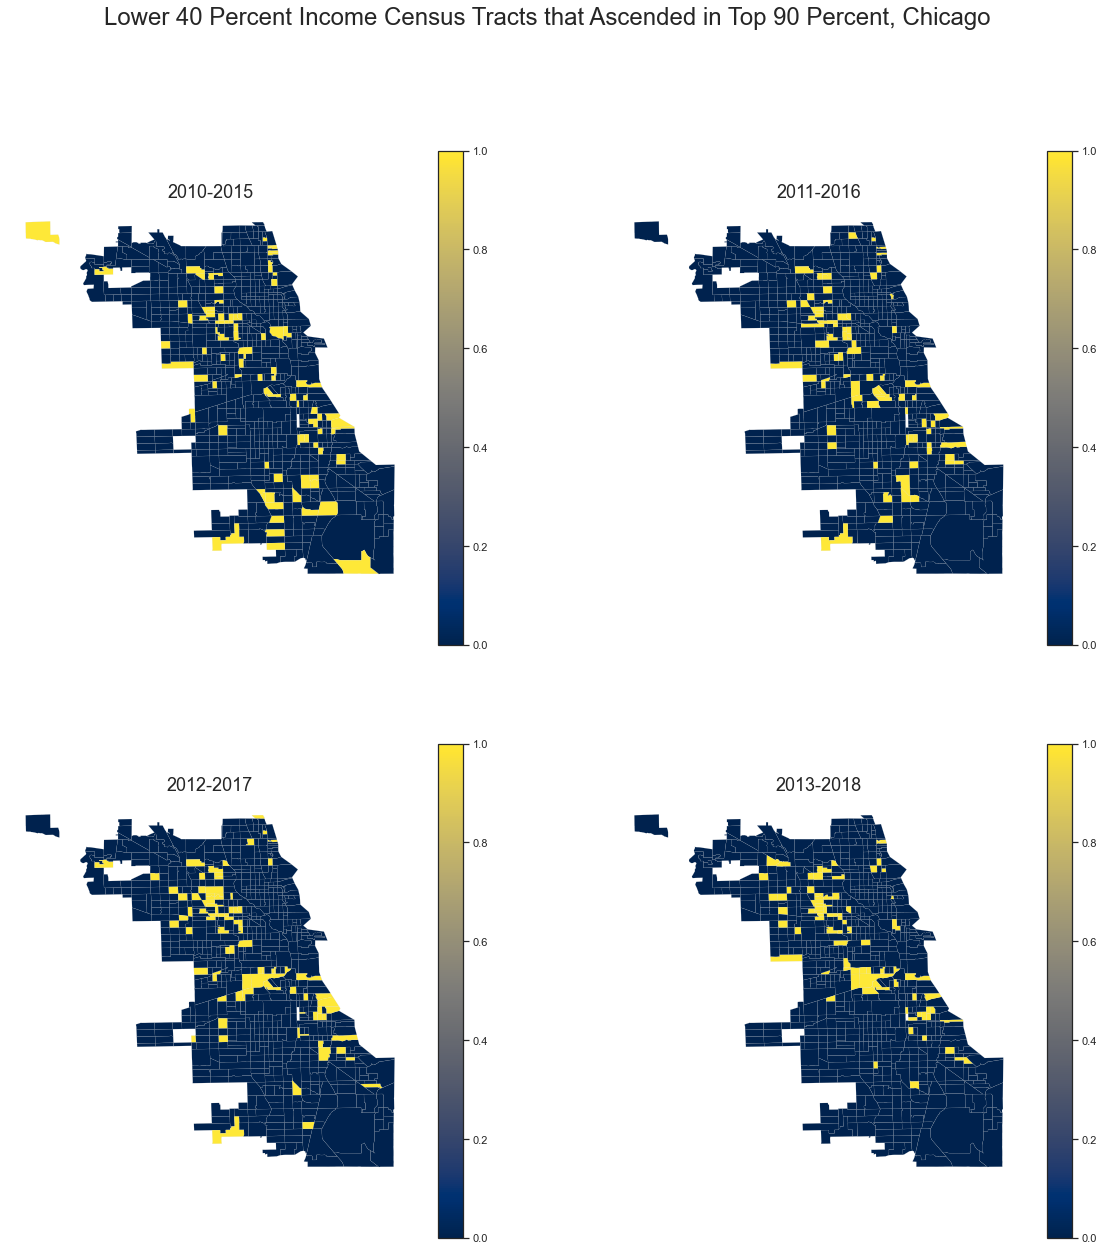

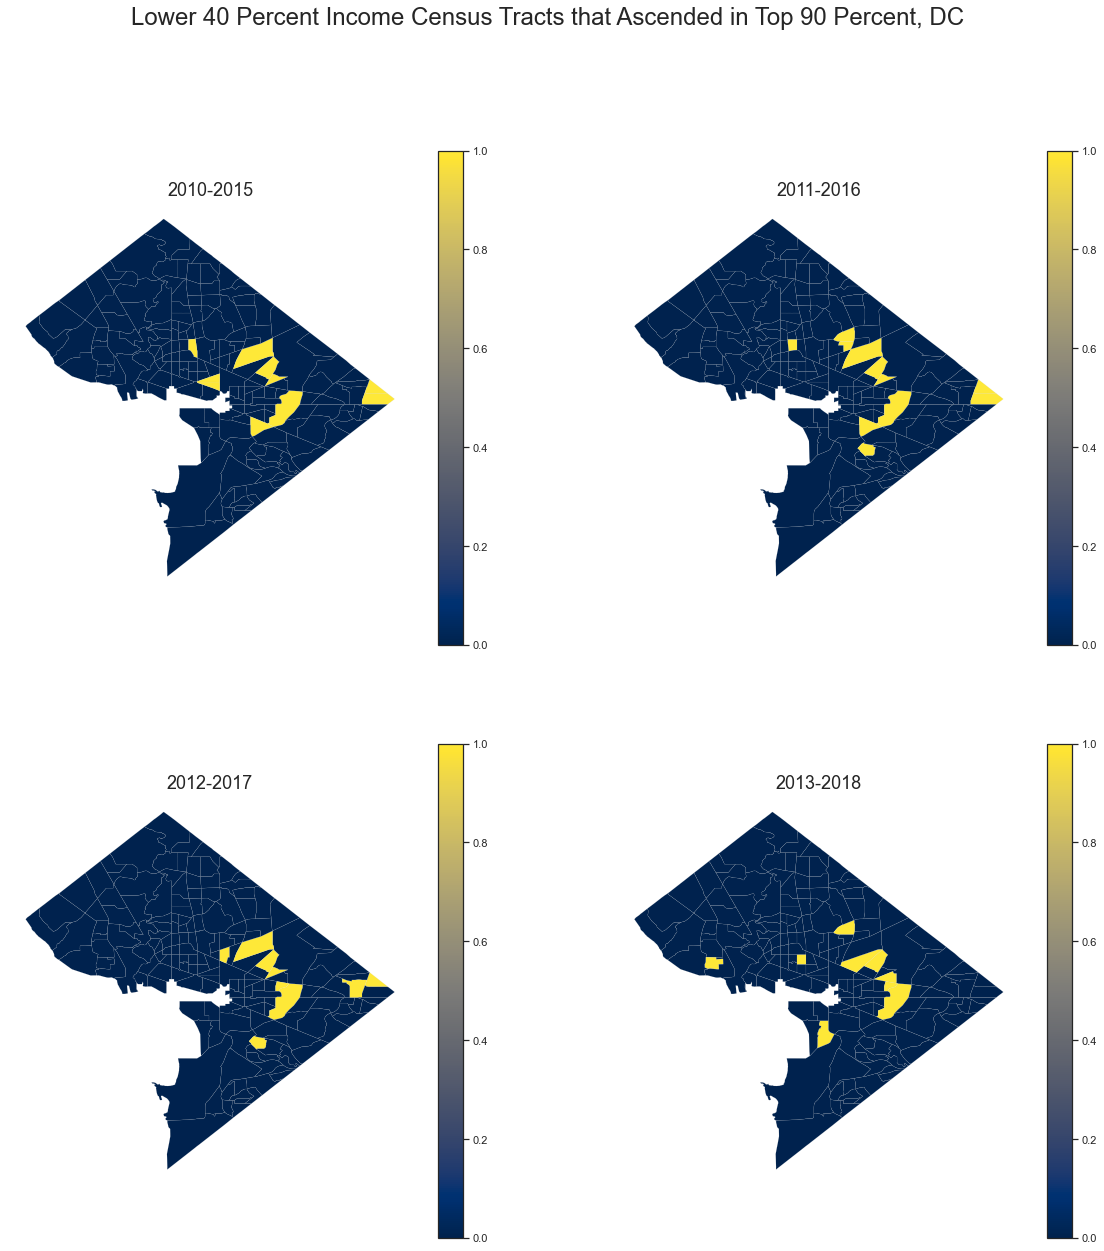

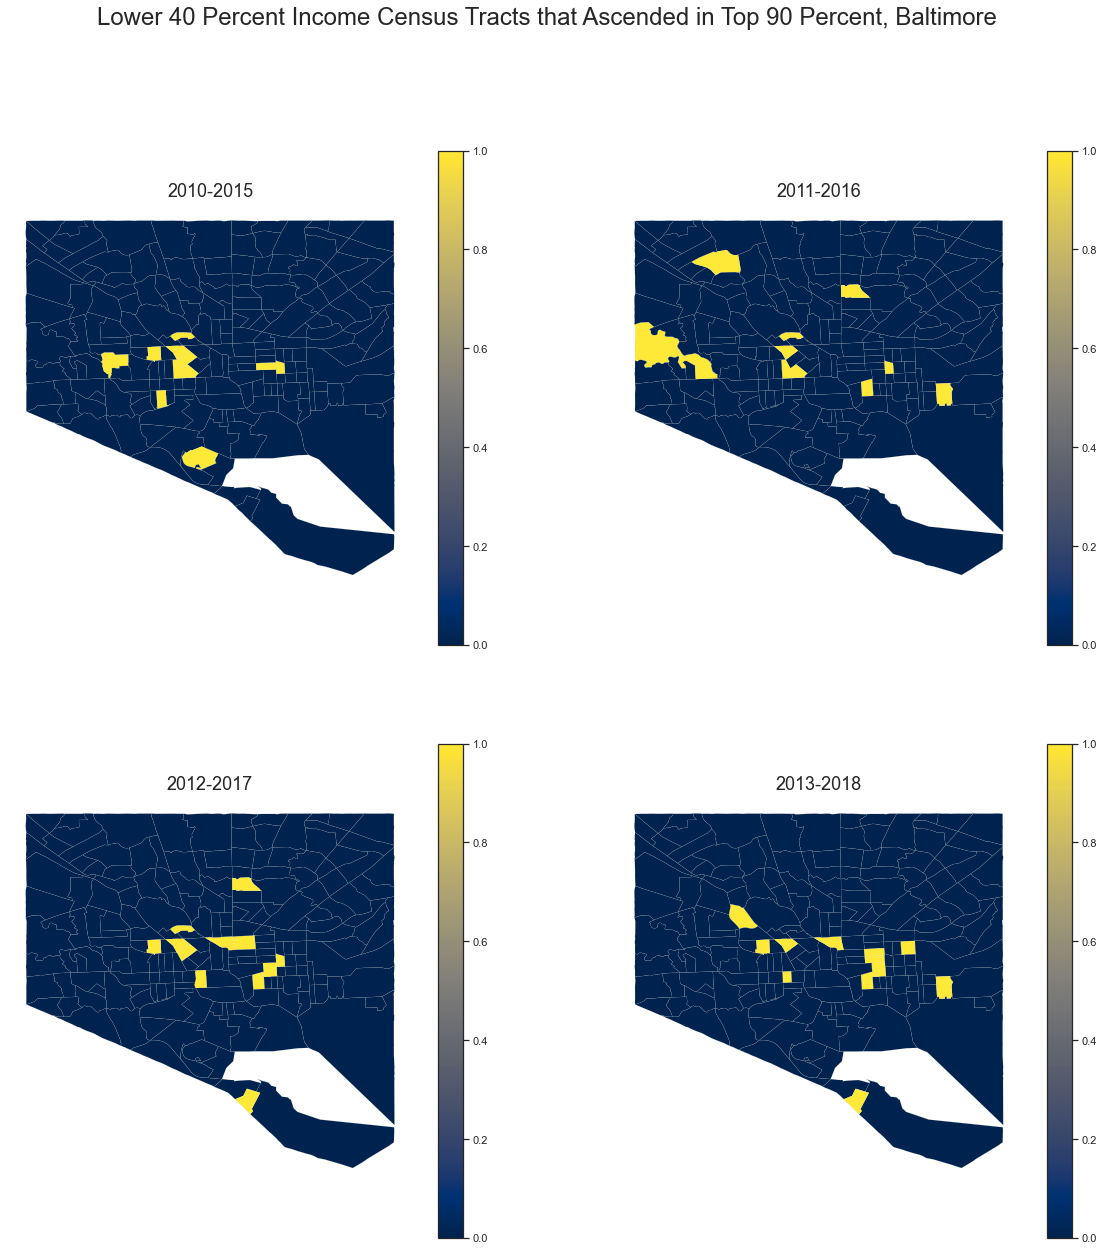

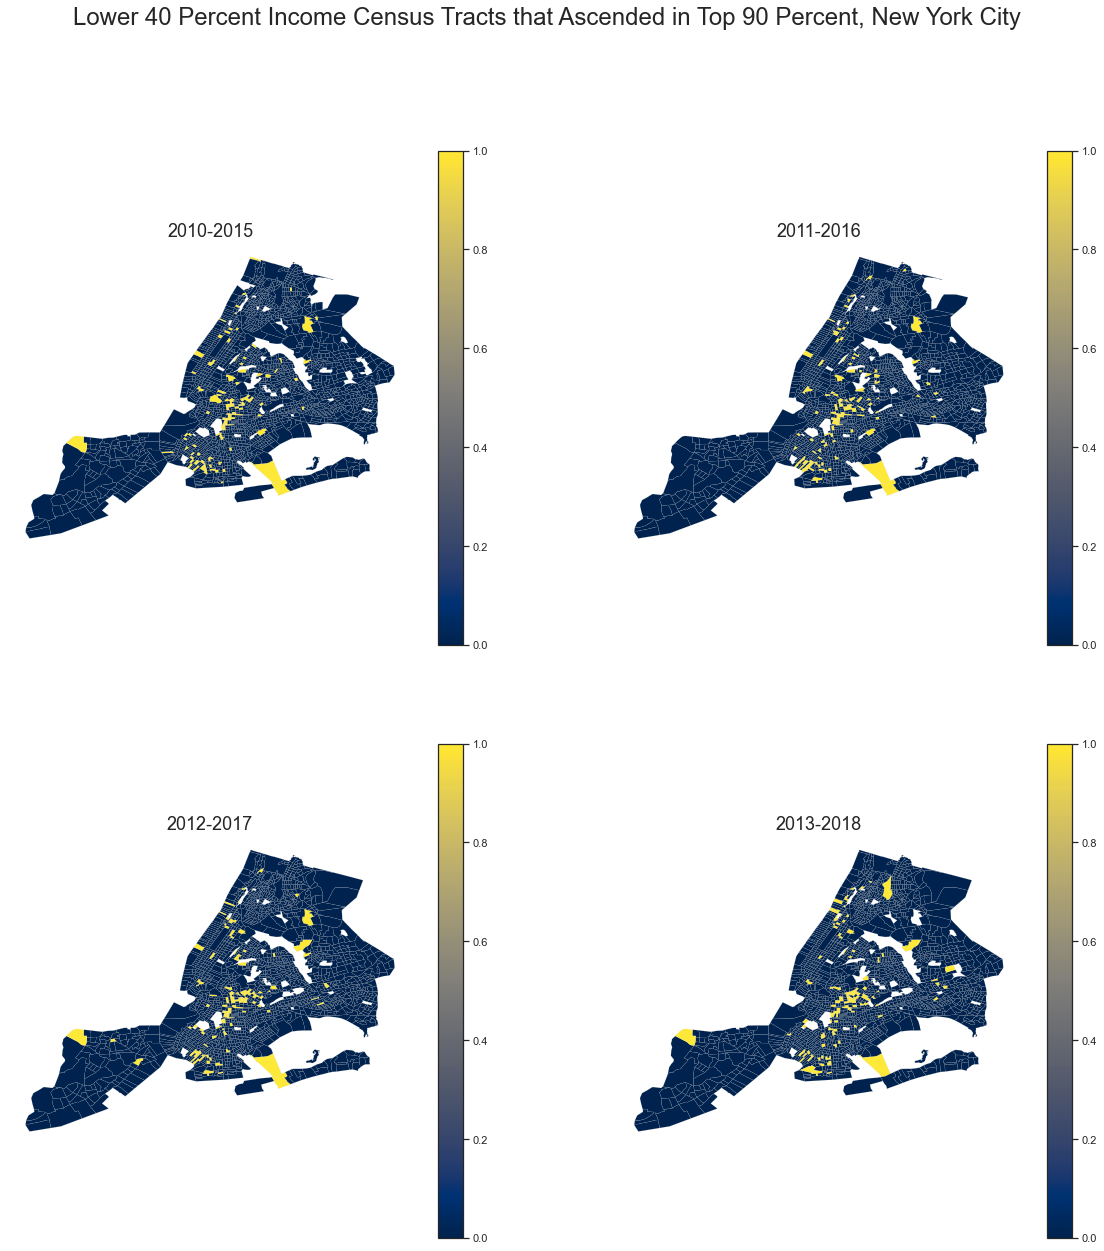

In [31]:
find_lower_income_ascent(merged_list, q=10, lb=4, ub=9)
create_map(chicago, merged_list, 'Lower Income Ascent', 'Lower 40 Percent Income Census Tracts that Ascended in Top 90 Percent, Chicago')
create_map(GDF_DICT['District of Columbia'], merged_list, 'Lower Income Ascent', 'Lower 40 Percent Income Census Tracts that Ascended in Top 90 Percent, DC')
create_map(GDF_DICT['Maryland'], merged_list, 'Lower Income Ascent', 'Lower 40 Percent Income Census Tracts that Ascended in Top 90 Percent, Baltimore')
create_map(GDF_DICT['New York'], merged_list, 'Lower Income Ascent', 'Lower 40 Percent Income Census Tracts that Ascended in Top 90 Percent, New York City')